# Coin autoencoder

http://www.machinelearninguru.com/deep_learning/tensorflow/neural_networks/autoencoder/autoencoder.html
https://jmetzen.github.io/2015-11-27/vae.html


In [141]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd
from scipy import spatial
from collections import defaultdict
import os
import cv2
import itertools
import tensorflow.contrib.layers as lays
%matplotlib inline

## Datasets

In [142]:
def load_image_dataset(img_shape, path, ndata):
    w = img_shape[0]
    h = img_shape[1]
    c = img_shape[2]
    img_size = np.prod(img_shape)
    
    files  = os.listdir(path)[:2*ndata]
    file_num = len(files)
    assert file_num >= ndata, "%s %s" % (file_num, ndata)
    
    images = np.zeros([file_num, img_size])
    labels = np.zeros([file_num, 1])
    
    for i,f in enumerate(files):
        clear_output(True)
        print("%d: %s" % (i+1, f))

        f = os.path.join(path, f)
        img = cv2.imread(f) + 1e-3
        if c == 1:
            img = np.max(img, axis=2)
        img = cv2.resize(img, (w,h), interpolation = cv2.INTER_CUBIC).astype('float32')
        norm = img.max()+ 1e-3
        img = img.astype('float32') / norm        
        images[i] = np.reshape(img, img_size)
        labels[i,0] = 1
    idx = list(range(file_num))
    np.random.shuffle(idx)
    images = images[idx]
    labels = labels[idx]
    clear_output(True)
    return (
        img_shape,
        file_num,
        images[:ndata],
        labels[:ndata],
        images[-ndata:],
        labels[-ndata:])

def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [128, 128, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

## Load data

In [143]:
data_size = 1000
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_coins_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

File num   : 2000
Data size  : 1000
Train shape: [1000, 16384]
Test  shape: [1000, 16384]
Image shape: [128, 128, 1]


Train images:


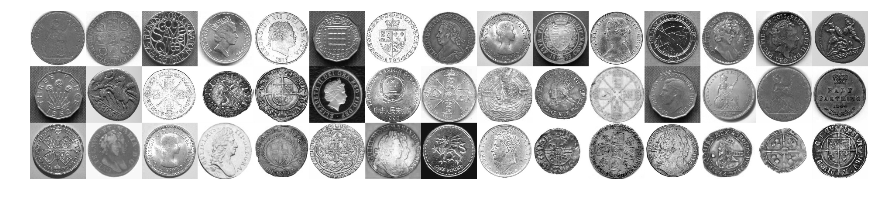

Test images:


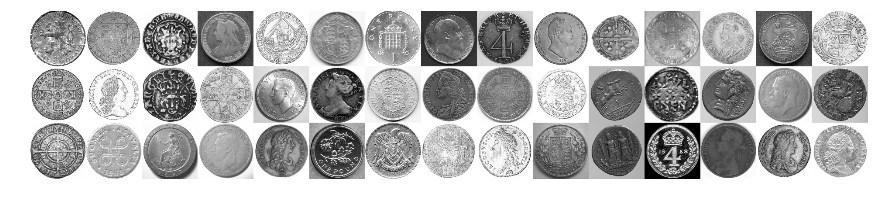

In [144]:
def show_images(images, image_shape, rows, cols):
    h = image_shape[0]
    w = image_shape[1]
    c = image_shape[2]

    n = rows*cols
    img = images[:n]
    img = np.reshape(img, [n*h, w])
    sheet = np.zeros([rows*h, cols*w])

    for i, j in itertools.product(range(rows), range(cols)):
        H = (i*cols+j) * h
        sheet[i*h:i*h+h, j*w:j*w+w] = img[H: H+h, 0:w]

    plt.figure(figsize = (15,7))
    plt.axis("off")
    plt.imshow(sheet, cmap='gray')
    plt.show()
print("Train images:")
show_images(train_images, image_shape, rows=3, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=3, cols=15)

## TF Neural Networks

In [149]:
def Autoencoder(inputs):
    l = tf.reshape(inputs, shape=[-1,] + image_shape)
    # encoder
    l = lays.conv2d(l,  8, [3, 3], 1)
    l = lays.conv2d(l, 16, [3, 3], 1)
    l = lays.conv2d(l, 32, [3, 3], 2)
    l = lays.conv2d(l, 64, [3, 3], 2)
    l = lays.conv2d(l,128, [3, 3], 2)
    l = lays.conv2d(l,128, [3, 3], 2)
    
    # features
    f = lays.flatten(l)
    
    # decoder
    l = lays.conv2d_transpose(l,128, [3, 3], 2)
    l = lays.conv2d_transpose(l, 64, [3, 3], 2)
    l = lays.conv2d_transpose(l, 32, [3, 3], 2)
    l = lays.conv2d_transpose(l, 16, [3, 3], 2)
    l = lays.conv2d_transpose(l,  8, [3, 3], 1)
    l = lays.conv2d_transpose(l,  1, [3, 3], 1, activation_fn=tf.nn.tanh)
    l = lays.flatten(l)
    return l, f


### Graph

In [150]:
learning_rate = 1e-4

with tf.device('/gpu:0'):
    ae_inputs  = tf.placeholder(dtype=tf.float32, shape=[None, np.prod(image_shape)], name='ae_inputs')
    ae_outputs, ae_features = Autoencoder(ae_inputs)
    
    ae_loss   = tf.reduce_mean(tf.square(ae_outputs - ae_inputs))
    train_op  = tf.train.AdamOptimizer(learning_rate).minimize(ae_loss)

### Train

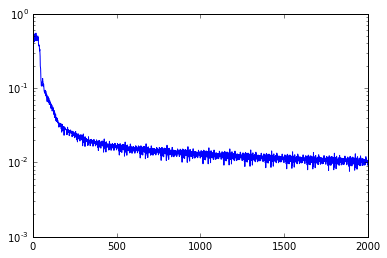

Step: 2000/2000 [100%], Cost: 9.22e-03
CPU times: user 4min 23s, sys: 1min 8s, total: 5min 32s
Wall time: 4min 54s


In [151]:
%%time

train_steps = 2000
batch_size  = 32

def plot_cost_trace(ct):
    plt.plot(ct)
    plt.yscale('log')
    plt.show()

def get_next_batch(i, bs):
    imgs = train_images[i:i+bs]
    lbls = train_labels[i:i+bs]
    i = (i + bs) % (len(train_images))
    return i, imgs, lbls

sess = tf.Session()

def do_train(loss, pl, bs):
    try:
        log_every   = 10
        costs       = []
        sess.run(tf.global_variables_initializer())
        bi = 0
        for step in range(train_steps):
            bi, images, _ = get_next_batch(bi, bs)
            _, c = sess.run([train_op, loss], feed_dict={pl : images})
            costs.append(c)

            if step%log_every == log_every - 1:
                clear_output(True)
                progress = "Step: %d/%d [%.0f%%], Cost: %.2e" % (step+1, train_steps, 100*(step+1)/train_steps, c)
                plot_cost_trace(costs)
    except KeyboardInterrupt:
        pass

    clear_output(True)
    plot_cost_trace(costs)
    print(progress)

do_train(ae_loss, ae_inputs, batch_size)

### Test autoencoder

Feature num: 8192


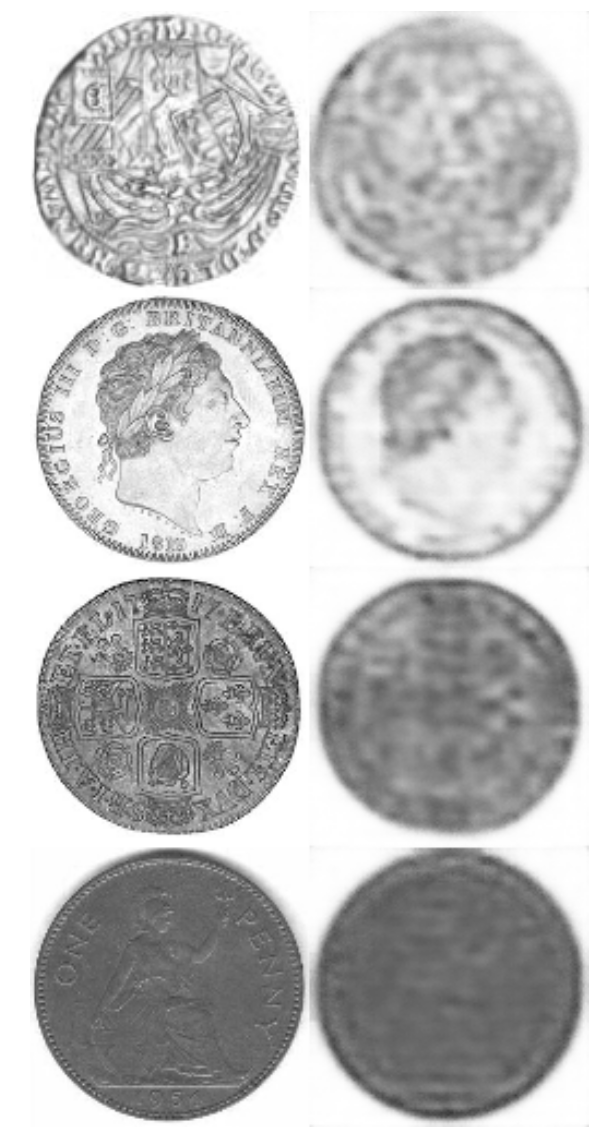

Feature num: 8192


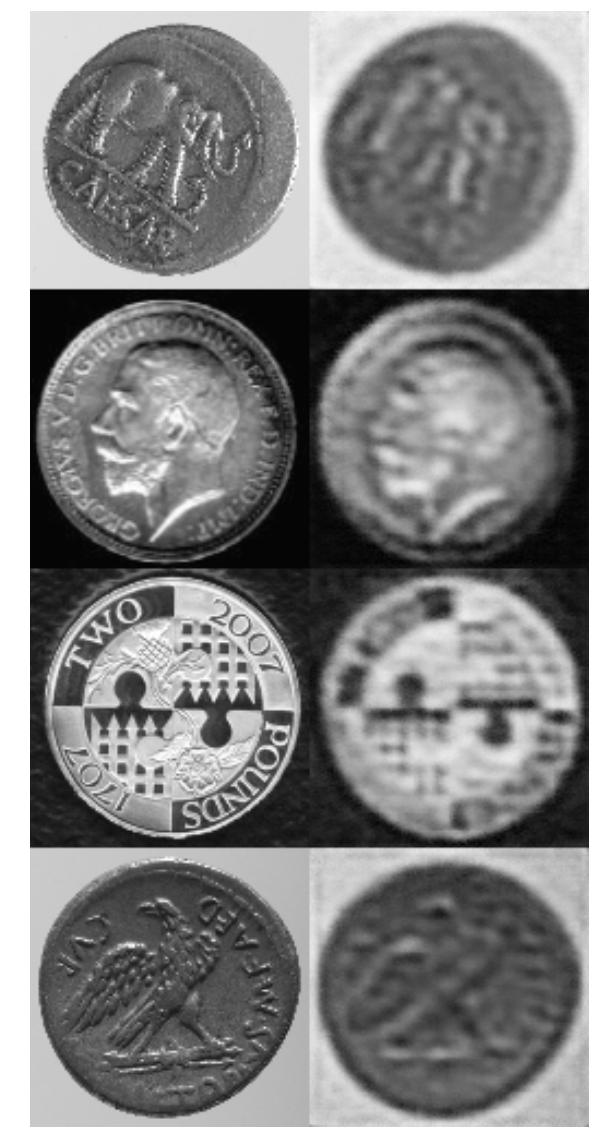

CPU times: user 2.44 s, sys: 240 ms, total: 2.68 s
Wall time: 2.36 s


In [152]:
%%time

def run_autoencoder(batch):
    return sess.run([ae_outputs, ae_features], feed_dict = {ae_inputs : batch})

def test_autoencoder(dataset, num):
    idx = np.random.choice(np.arange(len(dataset)), num)
    inputs  = dataset[idx]
    outputs, features = run_autoencoder(inputs)
    print("Feature num:", features.shape[1])
    
    h = image_shape[0]
    w = image_shape[1]
    img1 = inputs.reshape([num*h, w])
    img2 = outputs.reshape([num*h, w])
    sheet = np.concatenate([img1, img2], axis=1)
    plt.figure(figsize = (60,20))
    plt.axis("off")
    plt.imshow(sheet, cmap='gray');
    plt.show()

test_autoencoder(dataset = train_images, num = 4)
test_autoencoder(dataset = test_images,  num = 4)

### EOF